In [119]:
global file
file = input('Selet a folder') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [120]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

In [122]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [123]:
spacename = input('spacename plz?')
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)

In [124]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores,
    proposals.scores_total
])

In [125]:
proposals_choices = sg.query(proposals.choices)

In [126]:
proposals_choices = pd.DataFrame(proposals_choices)

In [127]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [128]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,Summary:\n\nProposal to add the XSTUSD/3CRV po...,4.535259e+04,5.745539e+05,Yes,No,None,None,None,None,None
1,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,Summary:\n\nProposal to add the XSTUSD/3CRV po...,5.292013e+05,5.745539e+05,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None
2,Add a new base pool implementation as an alter...,0x43c689ef6b7b1772abc033cd87b7caa4159f0dc281f9...,Read more: https://gov.curve.fi/t/adding-a-2po...,8.683418e+04,4.272657e+06,Yes,No,None,None,None,None,None
3,Add a new base pool implementation as an alter...,0x43c689ef6b7b1772abc033cd87b7caa4159f0dc281f9...,Read more: https://gov.curve.fi/t/adding-a-2po...,9.017389e+05,4.272657e+06,Ethereum Mainnet,Optimism,Arbitrum,Polygon,None,None,None
4,Add a new base pool implementation as an alter...,0x43c689ef6b7b1772abc033cd87b7caa4159f0dc281f9...,Read more: https://gov.curve.fi/t/adding-a-2po...,3.284084e+06,4.272657e+06,yes,no,None,None,None,None,None


In [129]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,Summary:\n\nProposal to add the XSTUSD/3CRV po...,4.535259e+04,5.745539e+05,Yes,No,None,None,None,None,None
1,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,Summary:\n\nProposal to add the XSTUSD/3CRV po...,5.292013e+05,5.745539e+05,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None
2,curve.eth,Add a new base pool implementation as an alter...,0x43c689ef6b7b1772abc033cd87b7caa4159f0dc281f9...,Read more: https://gov.curve.fi/t/adding-a-2po...,8.683418e+04,4.272657e+06,Yes,No,None,None,None,None,None
3,curve.eth,Add a new base pool implementation as an alter...,0x43c689ef6b7b1772abc033cd87b7caa4159f0dc281f9...,Read more: https://gov.curve.fi/t/adding-a-2po...,9.017389e+05,4.272657e+06,Ethereum Mainnet,Optimism,Arbitrum,Polygon,None,None,None
4,curve.eth,Add a new base pool implementation as an alter...,0x43c689ef6b7b1772abc033cd87b7caa4159f0dc281f9...,Read more: https://gov.curve.fi/t/adding-a-2po...,3.284084e+06,4.272657e+06,yes,no,None,None,None,None,None
5,curve.eth,Proposal to Launch Curve on Celo,0xa11d4d1800b91746afe8ead922eb1d37225a32145adf...,Summary:\n\nThe Celo community is proposing to...,2.609730e+07,2.609730e+07,Ethereum Mainnet,Optimism,Arbitrum,Polygon,None,None,None
6,curve.eth,Proposal to Launch Curve on Celo,0xa11d4d1800b91746afe8ead922eb1d37225a32145adf...,Summary:\n\nThe Celo community is proposing to...,0.000000e+00,2.609730e+07,sì,no,None,None,None,None,None
7,curve.eth,Launch RocketPool rETH pool to promote decentr...,0xc22db2c066d63fb09009b7b289205cd50bb38ce5c935...,Discussion:\nhttps://gov.curve.fi/t/launch-roc...,0.000000e+00,0.000000e+00,会,不会,None,None,None,None,None
8,curve.eth,Launch RocketPool rETH pool to promote decentr...,0xc22db2c066d63fb09009b7b289205cd50bb38ce5c935...,Discussion:\nhttps://gov.curve.fi/t/launch-roc...,0.000000e+00,0.000000e+00,OUI,NON,None,None,None,None,None
9,curve.eth,Launch RocketPool rETH pool to promote decentr...,0xc22db2c066d63fb09009b7b289205cd50bb38ce5c935...,Discussion:\nhttps://gov.curve.fi/t/launch-roc...,0.000000e+00,0.000000e+00,YES,NO,None,None,None,None,None


In [130]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [131]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

472

In [132]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

'0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b5628b7509f4338022db5'

In [133]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [134]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [135]:
voting_snapshots_list.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp
0,0xb25652cbf6ebc6f3f2643a54979621d4b76f0612f8b0...,0x800Ed249c34Ffc7A104fdC01b13F9913e3344CC9,1651819573,1,869.301820
1,0x051258875176fc1e5b70357efa10e7eede06d2c6800e...,0x082B9B776E5d0b1771594676D12619F479B0a69c,1651818915,1,8.409960
2,0x6d814c6976b93229169703b94fc322fffe74156166b8...,0x71A1dF0d820d29c784C04865904492aC38801A04,1651818623,2,1809.940456
3,0x6500978b6cd9ef770d125691122b7a0596d1f47c1c01...,0x481bb04f60DD1F7d6EC0A3611ed8023e618697CB,1651805125,2,0.098646
4,0xb1cbcf9e8080168294cdd9c49b2814192adee4a4dd7d...,0xaF9655eD0b27A2143bd4F099f9f2F1CF3c6DCC6F,1651790916,2,19.754227
5,0x41cecd77f5f5dcc5f8cb87656ade73428005edf3b2b9...,0x0BF93eA5a1FA4CE3Dd22C7ffd314462d3869777F,1651785544,2,45.758802
6,0x64c59855b4b5762061358518f12b274c0c46b038f99f...,0x852E45eD1a6502406Af4c409DF4e0Eef3CC0A0E3,1651780269,2,450.298161
7,0x1a322e8f1debd628085b29645d1f23fce0d54b4ce7f6...,0xfd6a653F95fB5BbFFC0F8478f5C198376214c6A3,1651756119,2,24.968811
8,0x75dc495ba04141be900291e88a7181b7d63deefc5853...,0x4e15aC6D5F8A6b5c5a84436955C9f38F4195Bf61,1651741559,2,107.490388
9,0xb21f1d809d4e548586b1b5a3ead8cd43e5fe600bde45...,0xaCE1f1c6c5c89AE3Fc3209ff92e7120fb74445aA,1651738530,1,81.773234


In [136]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,4))
    ##clear_output(wait=True)
    if progress%5==0:
        print("Progress",progress,"%")

print(len(voting_snapshots_list),' records')

Progress 25.0 %
Progress 50.0 %
Progress 75.0 %
Progress 100.0 %
4567  records


In [137]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [138]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,Proposal,DAO,proposals_title,proposals_id,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6
0,0xb25652cbf6ebc6f3f2643a54979621d4b76f0612f8b0...,0x800Ed249c34Ffc7A104fdC01b13F9913e3344CC9,1.651820e+09,1.0,869.301820,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,45352.592228,574553.874247,Yes,No,None,None,None,None,None
1,0xb25652cbf6ebc6f3f2643a54979621d4b76f0612f8b0...,0x800Ed249c34Ffc7A104fdC01b13F9913e3344CC9,1.651820e+09,1.0,869.301820,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,529201.282019,574553.874247,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None
2,0x051258875176fc1e5b70357efa10e7eede06d2c6800e...,0x082B9B776E5d0b1771594676D12619F479B0a69c,1.651819e+09,1.0,8.409960,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,45352.592228,574553.874247,Yes,No,None,None,None,None,None
3,0x051258875176fc1e5b70357efa10e7eede06d2c6800e...,0x082B9B776E5d0b1771594676D12619F479B0a69c,1.651819e+09,1.0,8.409960,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,529201.282019,574553.874247,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None
4,0x6d814c6976b93229169703b94fc322fffe74156166b8...,0x71A1dF0d820d29c784C04865904492aC38801A04,1.651819e+09,2.0,1809.940456,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,45352.592228,574553.874247,Yes,No,None,None,None,None,None
5,0x6d814c6976b93229169703b94fc322fffe74156166b8...,0x71A1dF0d820d29c784C04865904492aC38801A04,1.651819e+09,2.0,1809.940456,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,529201.282019,574553.874247,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None
6,0x6500978b6cd9ef770d125691122b7a0596d1f47c1c01...,0x481bb04f60DD1F7d6EC0A3611ed8023e618697CB,1.651805e+09,2.0,0.098646,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,45352.592228,574553.874247,Yes,No,None,None,None,None,None
7,0x6500978b6cd9ef770d125691122b7a0596d1f47c1c01...,0x481bb04f60DD1F7d6EC0A3611ed8023e618697CB,1.651805e+09,2.0,0.098646,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,529201.282019,574553.874247,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None
8,0xb1cbcf9e8080168294cdd9c49b2814192adee4a4dd7d...,0xaF9655eD0b27A2143bd4F099f9f2F1CF3c6DCC6F,1.651791e+09,2.0,19.754227,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,45352.592228,574553.874247,Yes,No,None,None,None,None,None
9,0xb1cbcf9e8080168294cdd9c49b2814192adee4a4dd7d...,0xaF9655eD0b27A2143bd4F099f9f2F1CF3c6DCC6F,1.651791e+09,2.0,19.754227,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,curve.eth,Proposal to add XSTUSD-3CRV to the Gauge Contr...,0x0eb23ea0b877666ad3ddcd0d7da0114acdfe5ae6390b...,529201.282019,574553.874247,Do Nothing,2Pool + current 3Pool,2Pool + current 3Pool + 4Pool,None,None,None,None


In [139]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [140]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created"
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentange_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentange_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) voters_counted "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       ""
                       "Order by "
                       "    Proposal, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentange_of_total_vp,cum_percentage_of_total_vp,cum_percentange_of_total_vp_stepped,proposal_voter_rank,voters_counted,percentage_voters_counted,percentage_voters_counted_stepped
0,curve.eth,0x00de90755a7da5b717960549f9bae307be6ec0b79a69...,0xf05e75e42272Ec60ba6157d647924FD2de7a9495,2,2067.793075,1.637837e+09,2067.793075,2198.443326,0.940571,0.940571,1.0,1,1,0.333333,33.0
1,curve.eth,0x00de90755a7da5b717960549f9bae307be6ec0b79a69...,0xe53085d26544dAF3BA8f66B2D1B108E285cc51f9,1,114.984548,1.637680e+09,2182.777623,2198.443326,0.052303,0.992874,1.0,2,2,0.666667,67.0
2,curve.eth,0x00de90755a7da5b717960549f9bae307be6ec0b79a69...,0xd9293636EE3Aa663fc563ADB0912B0705dAfb62c,1,15.665702,1.637651e+09,2198.443326,2198.443326,0.007126,1.000000,1.0,3,3,1.000000,100.0
3,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0xf05e75e42272Ec60ba6157d647924FD2de7a9495,1.0,1891.626696,1.645198e+09,1891.626696,6893.077811,0.274424,0.274424,0.0,1,1,0.076923,8.0
4,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0x96CC80292fa3A7045611EB84aE09DF8bd15936d2,1.0,1634.047221,1.645063e+09,3525.673917,6893.077811,0.237056,0.511480,1.0,2,2,0.153846,15.0
5,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0xB72eD8401892466Ea8aF528C1af1d0524bc5e105,1.0,1239.535758,1.645241e+09,4765.209675,6893.077811,0.179823,0.691304,1.0,3,3,0.230769,23.0
6,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0x9eA8848e5b2D74B371F4dF19b1e5E6B251CC0237,1.0,871.755848,1.645073e+09,5636.965523,6893.077811,0.126468,0.817772,1.0,4,4,0.307692,31.0
7,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0xE87a10d5B212D169CCBC9a50Cf5E23DD3da27cb6,1.0,641.047212,1.645109e+09,6278.012735,6893.077811,0.092999,0.910771,1.0,5,5,0.384615,38.0
8,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0x3070f20f86fDa706Ac380F5060D256028a46eC29,1.0,402.086535,1.645068e+09,6680.099269,6893.077811,0.058332,0.969102,1.0,6,6,0.461538,46.0
9,curve.eth,0x026a69e5c9780479332d88fa9779a3cec5a9479d05cc...,0x0A251dF99A88A20a93876205Fb7f5Faf2E85A481,1.0,187.029901,1.645033e+09,6867.129170,6893.077811,0.027133,0.996235,1.0,7,7,0.538462,54.0


In [141]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

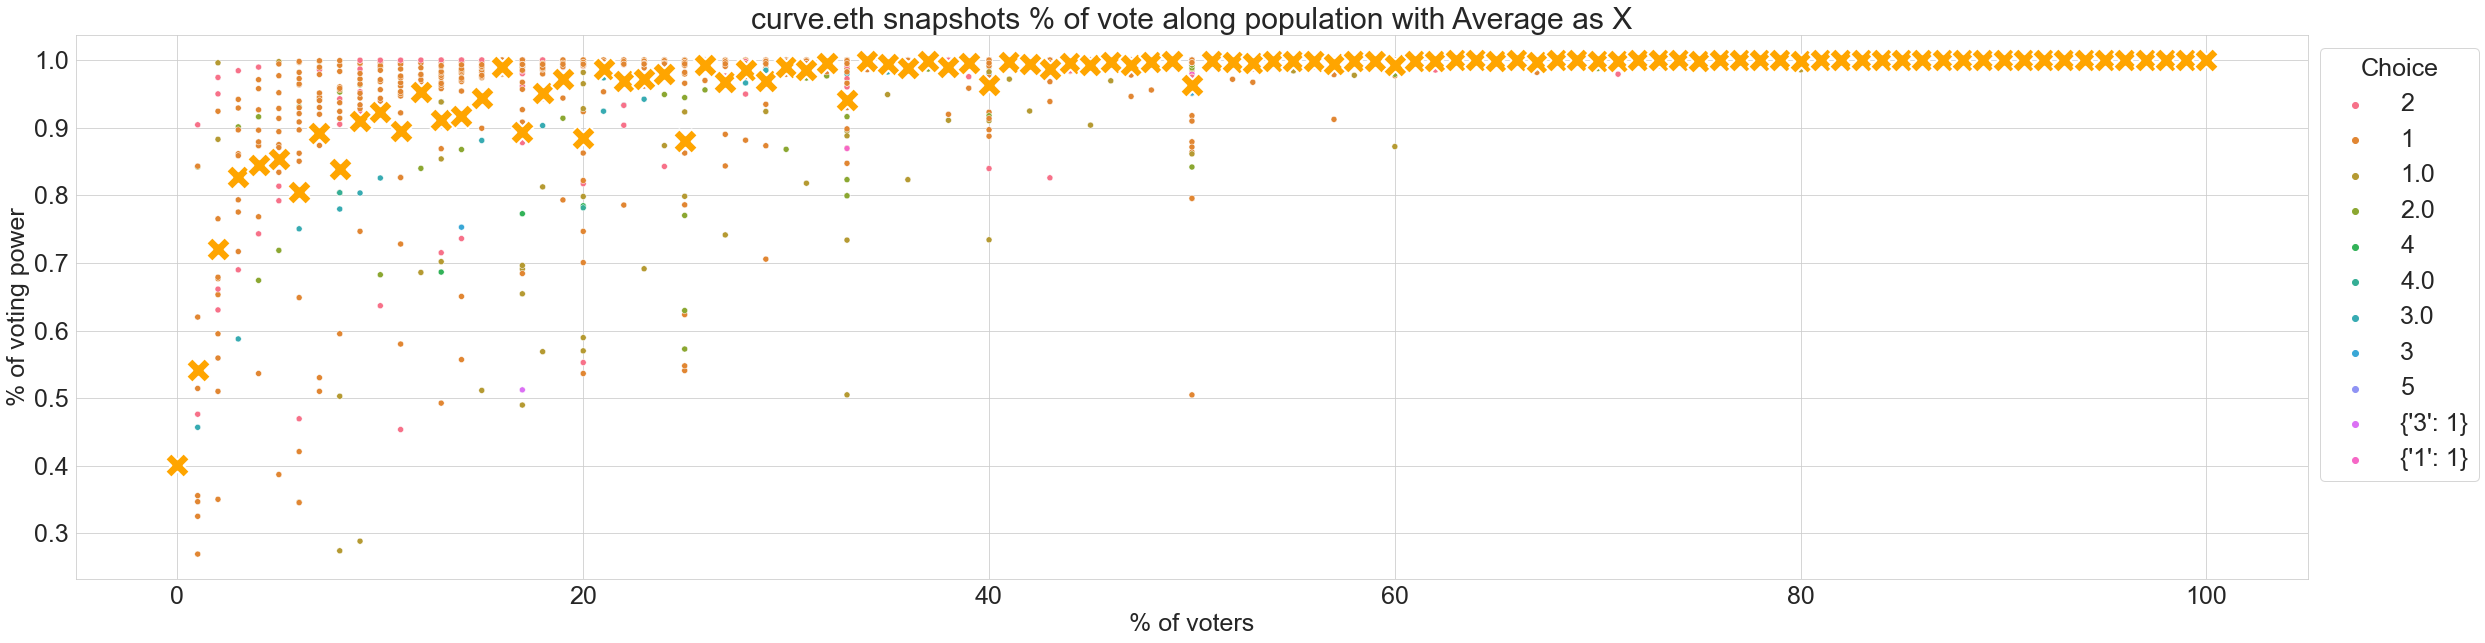

In [163]:
#plt.rc("figure", figsize=(40, 10))
sns.set_style("darkgrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'
sns.set_style("whitegrid")

#ax=sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp", s=500,marker='X',color = 'orange', legend=False)
#sns.lineplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped", hue="Proposal",zorder=-3).set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')#, legend=False)
ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped",hue='votes_choice').set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
plt.legend(title='Choice', ncol=1, bbox_to_anchor = (1,1))

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.

The Orange X shows the average % of power accumulated across all elections.